In [36]:
import xarray as xr 
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf
# from tensorflow.keras import utils
import pandas as pd
import os

import sys
# sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')
# from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod
# from gewitter_functions import get_acc

import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import shap


In [80]:
region_id = 0

In [198]:
ds_train = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/train_trim.nc').isel(time = slice(0,500))
ds_val = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/validate.nc').isel(time = slice(0,500))



In [199]:
#select all data with ARs in region plus 2x random data with no AR in the region 
all_y = np.array(ds_train.labels_1d)
regional_ar_index = np.argwhere(np.max(all_y[:,[region_id,region_id+10]],1)==1)[:,0]

No_regional_ar_index = (np.argwhere(np.max(all_y[:,[region_id,region_id+10]],1)!=1)[:,0])
np.random.shuffle(No_regional_ar_index)
No_regional_ar_index  = np.sort(No_regional_ar_index[0:2*len(regional_ar_index)])

ds_train_region = ds_train.isel(time = np.sort(np.append(regional_ar_index, No_regional_ar_index)))

In [200]:
# for testing, just select 500 timesteps for training

X_train = ds_train_region.isel(time = slice(0,500)).stack(data=['n_channel','lon', 'lat']).features
Y_train = np.max(ds_train_region.isel(time = slice(0,500)).labels_1d.values[:,[0,10]],1)

#create xgb data matrix for model input
data_test = xgb.DMatrix(X_train,Y_train)

In [206]:
#create model - input paramters here 
m = XGBClassifier(
    learning_rate = .1, 
    n_estimators=2000,
    max_depth = 10, #max depth of trees
    min_child_weight = 1, #smaller to allow small leves
    gamma = 0,
    subsample = .8,
    colsample_bytree = 0.8,
    objective = 'binary:logistic',
    scale_pos_weight=1,
    seed=27)


In [207]:
# fit the model - this takes a while
m.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [208]:
m.best_iteration

1999

In [209]:

X_val = ds_val.stack(data=['n_channel','lon', 'lat']).features
Y_val = np.max(ds_val.labels_1d.values[:,[0,10]],1)

In [210]:
# predict validation timesteps
y_pred = m.predict(X_val)

In [211]:
#create list of model variables
parameters= []
list_channels = np.array(X_train.n_channel)
for i in range(len(list_channels)):
    parameters.append(list_channels[i]+'_'+str(i))

In [212]:
results = pd.DataFrame({'time':np.array(X_val.time), 'Y_Val':Y_val, 'Y_pred':y_pred}).set_index('time')


In [213]:
tp = np.where((results.Y_Val==1) & (results.Y_pred==1),1,0).sum()
fp = np.where((results.Y_Val==0) & (results.Y_pred==1),1,0).sum()
tn = np.where((results.Y_Val==0) & (results.Y_pred==0),1,0).sum()
fn = np.where((results.Y_Val==1) & (results.Y_pred==0),1,0).sum()

print('true pos: '+str(np.round(tp/len(results.Y_pred)*100,0))+'%')
print('false pos: '+str(np.round(fp/len(results.Y_pred)*100,0))+'%')
print('true neg: '+str(np.round(tn/len(results.Y_pred)*100,0))+'%')
print('false neg: '+str(np.round(fn/len(results.Y_pred)*100,0))+'%')

print('Accuracy: '+str(np.round(np.where((results.Y_Val== results.Y_pred),1,0).sum()/len(results.Y_pred)*100,0))+'%')



true pos: 7.0%
false pos: 6.0%
true neg: 80.0%
false neg: 7.0%
Accuracy: 87.0%


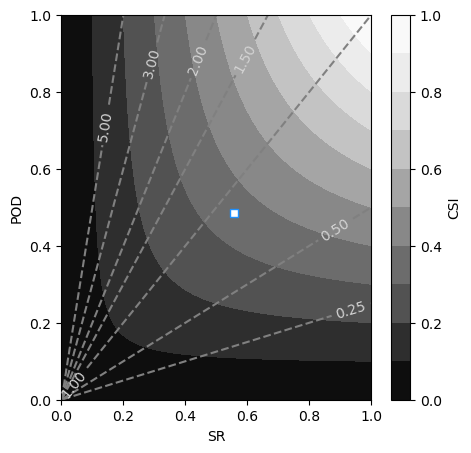

In [214]:
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '/projects/reba1583/Research3/WAF_ML_Tutorial_Part2/scripts/')
#load contingency_table func
from gewitter_functions import get_contingency_table,make_performance_diagram_axis,get_acc,get_pod,get_sr,csi_from_sr_and_pod

#calc x,y of performance diagram 
pod= tp/(tp + fn)
sr = tp/(tp + fp)
csi = tp/(tp + fn + fp)

fig,ax = plt.subplots(1,1,figsize=(5,5))

#plot it up  
make_performance_diagram_axis(ax)
ax.plot(sr,pod,'-s',color='dodgerblue',markerfacecolor='w')

In [32]:
#calculate shap values. this will be the same size as your input data. takes a while to run
shap_values = shap.TreeExplainer(m).shap_values(X_val)

In [34]:
np.shape(shap_values)

(50, 246240)

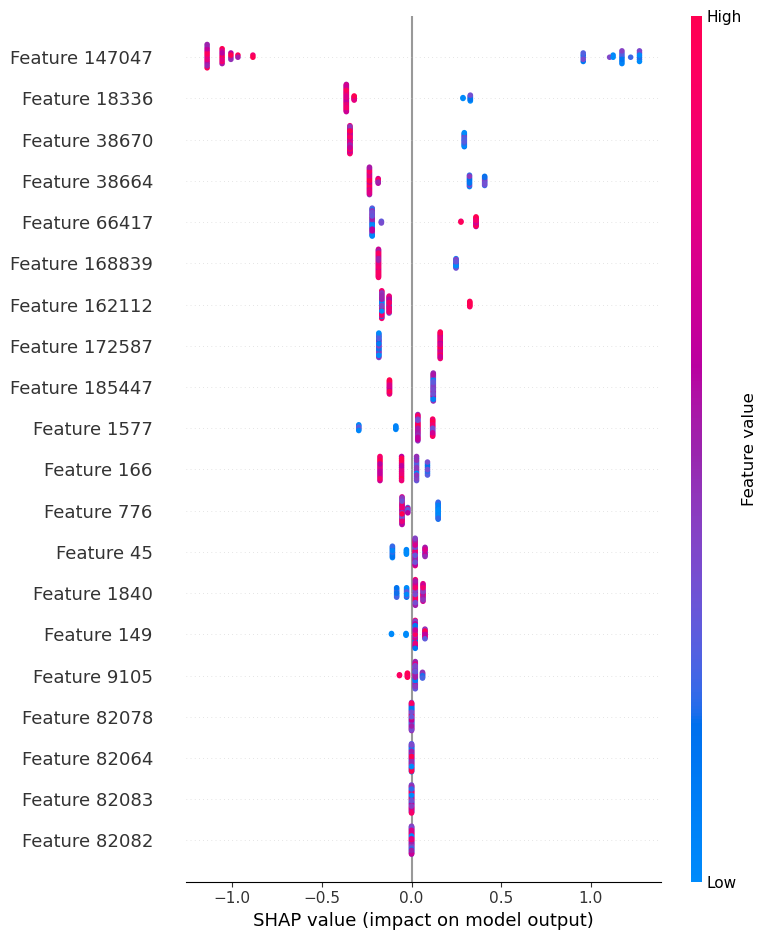

In [33]:
shap.summary_plot(shap_values, X_val)

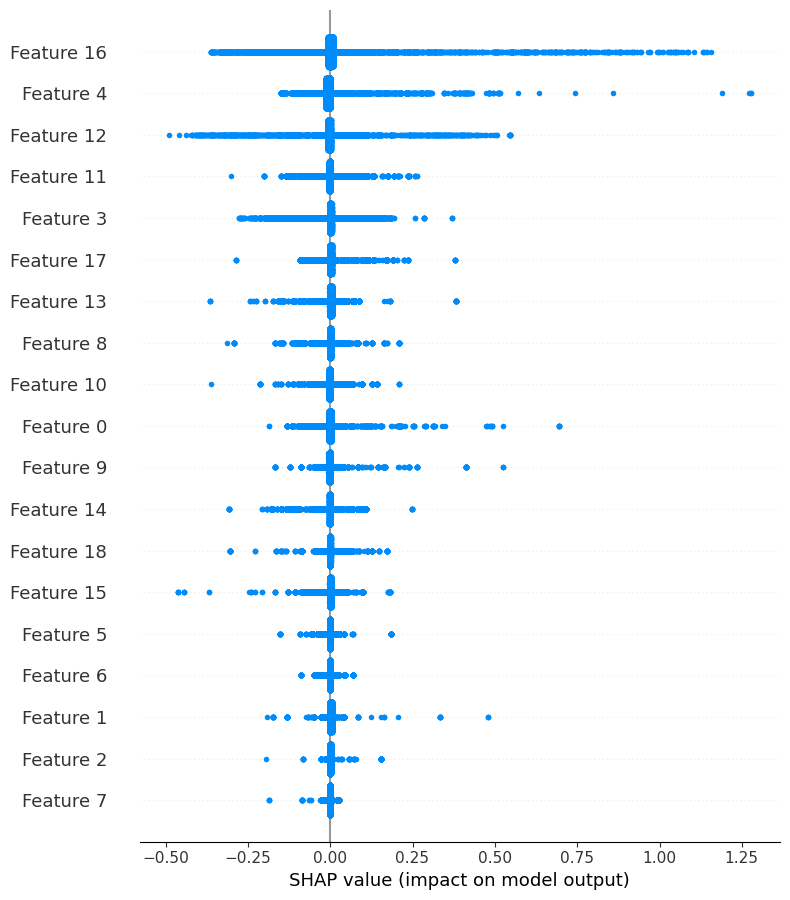

In [133]:
#not totally sure about the data re-arranging order but I think this returns shap values by variable
shap.summary_plot(np.reshape(np.split(shap_values, 19, axis = 1), (19,500*12960)).T)

In [137]:
np.array(ds_val.n_channel)[16]

'IWV_lead0'

In [138]:
np.array(ds_val.n_channel)[4]

'V800_lead0'

In [141]:
np.array(ds_val.n_channel)[3]

'U800_lead0'

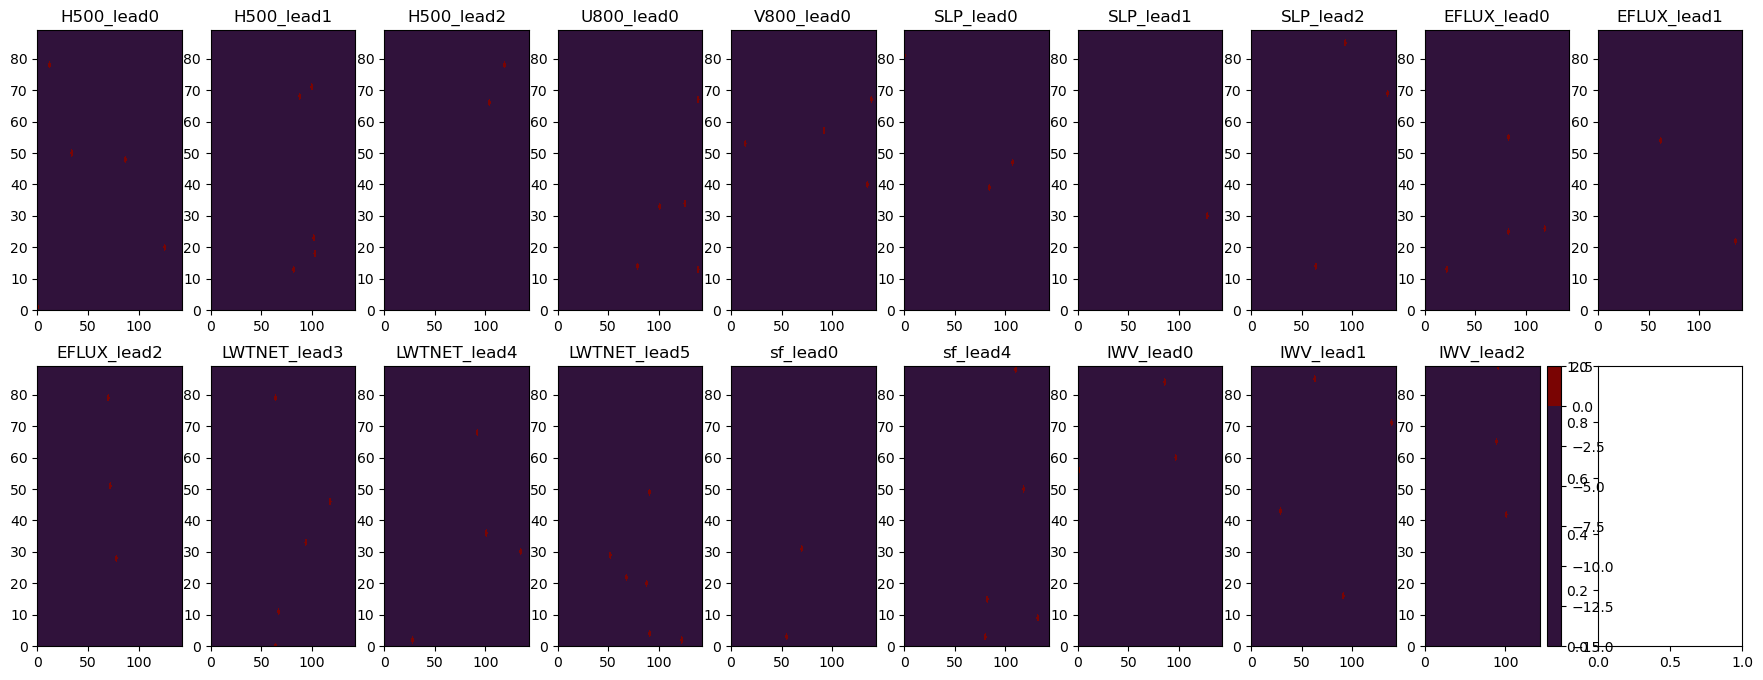

In [173]:
# attempt to map shap values - not sure if this worked
fig,axes = plt.subplots(2,10,figsize=(22,8))
axes = axes.flatten()
titles = [
    'H500_lead0', 'H500_lead1', 'H500_lead2','U800_lead0', 'V800_lead0','SLP_lead0', 'SLP_lead1', 'SLP_lead2',
    'EFLUX_lead0', 'EFLUX_lead1', 'EFLUX_lead2', 'LWTNET_lead3', 'LWTNET_lead4', 'LWTNET_lead5','sf_lead0','sf_lead4',
    'IWV_lead0', 'IWV_lead1', 'IWV_lead2',]
for a in range(len(axes)-1):
    fill = axes[a].contourf(ds_train_region.lon, ds_train_region.lat,total_time_shape[:,:,a].T,cmap='turbo', vmin = -.005, vmax = .005)
    axes[a].set_title(titles[a])
fig.colorbar(fill)

In [313]:
#make data seperated by variable, make into xarray dataset
shap = pd.DataFrame(shap_values, columns = parameters)

variable_names = np.array(ds_train.n_channel)
data = []
for i in range(len(variable_names)):
    variable_data = np.reshape(np.array(shap[shap.columns[pd.Series(shap.columns).str.startswith(variable_names[i])]]),(len(shap),144,90))
    data.append(variable_data)
var_data = dict(
    shap_values = ([ 'n_channel', 'time', 'lon', 'lat'], data)
)

coords = dict(
    time = (['time'], np.array(X_train.time)), 
    n_channel = (['n_channel'], np.array(variable_names)),
      
)
ds = xr.Dataset(
    data_vars = var_data, 
    coords = coords
)

In [6]:
# import xarray as xr 
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# import os

# import sys
# import xgboost as xgb
# from xgboost import XGBClassifier
# import shap

# region_id = 0

# ds_train = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/train_full.nc').isel(time = slice(0,100))
# ds_val = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/validate_full.nc').isel(time = slice(0,100))

# #select a reasonable amount of times with and without ARs in region (ocean and land)
# all_y = np.array(ds_train.labels_1d)
# regional_ar_index = np.argwhere(np.max(all_y[:,[region_id,region_id+10]],1)==1)[:,0]
# No_regional_ar_index = (np.argwhere(np.max(all_y[:,[region_id,region_id+10]],1)!=1)[:,0])
# np.random.shuffle(No_regional_ar_index)
# No_regional_ar_index  = np.sort(No_regional_ar_index[0:2*len(regional_ar_index)]) #here I choose twice as many no AR landfalls as landfall
# ds_train_region = ds_train.isel(time = np.sort(np.append(regional_ar_index, No_regional_ar_index)))

# X_train = ds_train_region.stack(data=['n_channel','lon', 'lat']).features #make x data 1d
# Y_train = np.max(ds_train_region.labels_1d.values[:,[region_id,region_id+10]],1)

# X_val = ds_val.stack(data=['n_channel','lon', 'lat']).features
# Y_val = np.max(ds_val.labels_1d.values[:,[region_id,region_id+10]],1)

# data_test = xgb.DMatrix(X_train,Y_train)

# m = XGBClassifier()

# m.fit(X_train, Y_train)

# Y_pred = m.predict(X_val)

# results = pd.DataFrame({'time':np.array(X_val.time), 'Y_Val':Y_val, 'Y_pred':Y_pred}).set_index('time')


# new_folder = '/rc_scratch/reba1583/TEST/'
# os.system('mkdir '+new_folder)

# results.to_csv(new_folder+'results.csv')


# shap_values = shap.TreeExplainer(m).shap_values(X_val)

# parameters= []
# list_channels = np.array(X_train.n_channel)
# for i in range(len(list_channels)):
#     parameters.append(list_channels[i]+'_'+str(i))

# shap = pd.DataFrame(shap_values, columns = parameters)

# variable_names = np.array(ds_train.n_channel)
# data = []
# for i in range(len(variable_names)):
#     variable_data = np.reshape(np.array(shap[shap.columns[pd.Series(shap.columns).str.startswith(variable_names[i])]]),(len(shap),144,90))
#     data.append(variable_data)

var_data = dict(
    shap_values = ([ 'n_channel', 'time', 'lon', 'lat'], data)
)

coords = dict(
    time = (['time'], np.array(X_val.time)), 
    n_channel = (['n_channel'], np.array(variable_names)),
      
)
ds_shap = xr.Dataset(
    data_vars = var_data, 
    coords = coords
)

ds_shap.to_netcdf(new_folder+'shap.nc')


m.save_model(new_folder+'model.json')


In [8]:
test = pd.read_csv(new_folder+'results.csv')

In [19]:
new_folder

'/rc_scratch/reba1583/TEST/'

In [14]:
np.where(test.Y_Val == test.Y_pred,1,0).sum()/len(test.Y_Val)

0.84

In [17]:
np.where((test.Y_Val == 1) & (test.Y_pred ==1),1,0).sum()

2

In [18]:
np.where((test.Y_Val == 1),1,0).sum()

12

In [72]:
ds_train = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/train_trim.nc').isel(time = slice(0,200))
ds_val = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/Combined_Daily_Data_CNN/validate.nc').isel(time = slice(100,200))


In [78]:
all_y = np.array(ds_train.labels_1d)
new_y = np.zeros(len(all_y))
for y in range(6):
    new_y[np.argwhere(all_y[:,y]==1)] = y+1
    new_y[np.argwhere(all_y[:,y+10]==1)] = y+1

In [71]:
np.shape(Y_train)

(200,)

In [75]:
# for testing, just select 500 timesteps for training

X_train = ds_train.stack(data=['n_channel','lon', 'lat']).features
Y_train = new_y

#create xgb data matrix for model input
data_test = xgb.DMatrix(X_train,Y_train)

(array([61., 16.,  0., 11.,  0., 13., 22.,  0., 24., 53.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

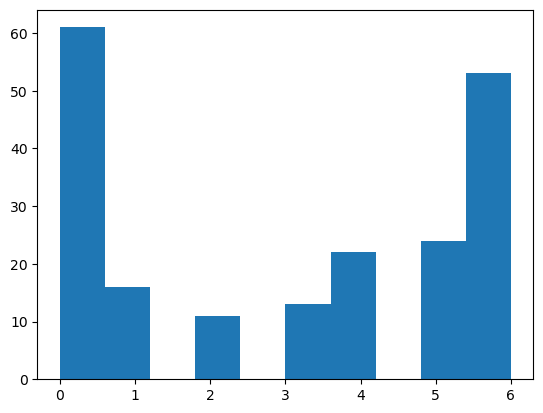

In [79]:
plt.hist(new_y)